# Chicago Taxi Rides in 2016
### Kevin Wang

For this project, I have been hired as a Sr. Data Scientist in Chicago and my manager has asked me to analyze a dataset of 20 million observations involving Chicago taxi trips in 2016. There are many missing values, which I will drop from the analysis.

My main topic of interest is to forecast fare based on trip_seconds and trip_miles, representing time and distance of trips. I will build and evaluate the following models:

1. Linear Regression with Elastic Net Regularization
2. Decision Tree
3. Random Forest
4. Gradient-Boosted Tree

I tune the hyperparameters for each model and compare them using RMSE and R2. Finally, I perform K-means clustering and recommend the optimal number of clusters.



## 1. Initialize a spark session

In [ ]:
!pip install -q findspark
!pip install -q pyspark

import findspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("Final_Project").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 2. Upload files and drop NAs

In [ ]:
# Mount google drive to directly access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read all csv files in folder from google drive
df = spark.read.options(inferSchema=True).csv('/content/drive/My Drive/taxitrips/*.csv', header=True)
print(df.count())

19866157


In [ ]:
# Only keep the columns needed for analysis: (taxi_id, trip_seconds, trip_miles, fare)
from pyspark.sql.functions import col
import numpy as np
import pandas as pd
df = df.select(col('taxi_id'), col('trip_seconds'), col('trip_miles'), col('fare'))

# Drop all rows with missing values in any of the three columns
df = df.na.drop(subset= ["fare","trip_seconds","trip_miles"])
df.printSchema()

root
 |-- taxi_id: integer (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- fare: double (nullable = true)



In [ ]:
import pyspark.sql.functions as F

# drop rows where trip_seconds and trip_miles equal 0 and fare > 0
df = df.filter(~((F.col('trip_seconds') == 0) & (F.col('trip_miles') == 0.0) & (F.col('fare') > 0.0)))

## 3. Process Data for Analysis

I use VectorAssembler to create features column and rename fare as label column. Next, I filter out outliers for trip_seconds, trip_miles and fare using 40.0 x IQR. Normal convention is to use 1.5 or 3.0 x IQR, but I only want to filter out extreme outliers. I generate histograms of the filtered data and randomly split the final dataset into training and test sets using a 7:3 split.



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# Create features vector column
assembler = VectorAssembler(inputCols=["trip_seconds", "trip_miles"], outputCol="features")
# Rename column
temp = df.withColumnRenamed("fare","label")
# Create final dataframe with label and features column
temp_df = assembler.transform(temp)

In [ ]:
# Summary statistics
temp_df.describe("trip_seconds","trip_miles", "label").toPandas()

,summary,trip_seconds,trip_miles,label
0,count,18283991,18283991,18283991
1,mean,833.2395106188796,3.687776817437554,13.763844179862032
2,stddev,1079.9953263549164,23.52953142874424,25.170068788649743
3,min,0,0.0,0.0
4,max,86399,3353.1,9999.0


In [ ]:
# Function to filter outliers from df based on factor x IQR upper bound (should be no difference as lowest value for all 3 variables is 0, so do not filter by lower bound)
def iqr_outlier(df, columns, factor=40.0):
    for column in columns:
        # Calculate Q1, Q3, and IQR using .approxQuantile()
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        # Define the upper bound for outliers
        upper_bound = q3 + (factor * iqr)
        # Filter outliers and update the df
        df = df.filter((col(column) <= upper_bound))
    return df

In [ ]:
# Invoke function to filter outliers
final_df = iqr_outlier(temp_df, ["trip_seconds","trip_miles","label"])

In [ ]:
# Summary statistics
final_df.describe("trip_seconds","trip_miles", "label").toPandas()

,summary,trip_seconds,trip_miles,label
0,count,18261021,18261021,18261021
1,mean,822.8428331581241,3.2141201502391166,13.649555748279337
2,stddev,782.2658607640693,5.397947768181209,12.60372209417868
3,min,0,0.0,0.0
4,max,27420,103.0,323.55


In [ ]:
import matplotlib.pyplot as plt
# For 3d plot in kmeans
from mpl_toolkits import mplot3d

In [ ]:
# Package for plotting histograms in PySpark
!pip install -q pyspark_dist_explore
from pyspark_dist_explore import hist

(array([2.494207e+06, 6.355628e+06, 3.392484e+06, 2.178814e+06,
        9.902990e+05, 8.469860e+05, 4.670660e+05, 4.315220e+05,
        3.200290e+05, 1.934360e+05, 1.815510e+05, 1.080730e+05,
        9.751200e+04, 5.489000e+04, 4.732500e+04, 3.087200e+04,
        1.716600e+04, 1.445500e+04, 7.801000e+03, 6.634000e+03,
        3.613000e+03, 3.276000e+03, 2.273000e+03, 1.464000e+03,
        1.464000e+03, 9.920000e+02, 1.079000e+03, 7.370000e+02,
        8.050000e+02, 7.150000e+02, 5.230000e+02, 5.690000e+02,
        3.840000e+02, 4.460000e+02, 3.310000e+02, 3.640000e+02,
        3.030000e+02, 2.320000e+02, 2.830000e+02, 1.950000e+02,
        2.050000e+02, 1.760000e+02, 1.950000e+02, 1.950000e+02,
        1.260000e+02, 1.390000e+02, 1.030000e+02, 1.330000e+02,
        8.600000e+01, 1.080000e+02, 1.080000e+02, 8.500000e+01,
        2.500000e+02, 7.600000e+01, 8.300000e+01, 7.200000e+01,
        8.600000e+01, 7.900000e+01, 4.500000e+01, 7.600000e+01,
        5.100000e+01, 6.600000e+01, 5.30

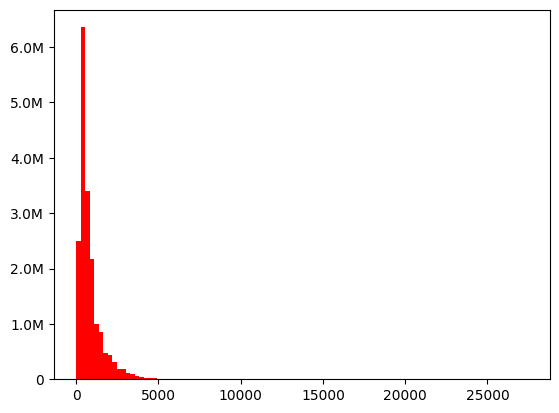

In [ ]:
# Plot histograms
fig, ax = plt.subplots()
hist(ax, final_df.select('trip_seconds'), bins = 100, color=['red'])

(array([8.168826e+06, 4.018474e+06, 1.583196e+06, 9.845580e+05,
        5.345790e+05, 3.785140e+05, 2.783540e+05, 1.777050e+05,
        1.305770e+05, 9.956900e+04, 1.158740e+05, 1.205180e+05,
        1.864900e+05, 1.487500e+05, 1.262290e+05, 1.139550e+05,
        3.555460e+05, 4.588890e+05, 8.236500e+04, 3.817700e+04,
        3.371200e+04, 1.264500e+04, 1.030600e+04, 1.292600e+04,
        1.073700e+04, 8.851000e+03, 7.850000e+03, 6.295000e+03,
        5.685000e+03, 6.670000e+03, 5.771000e+03, 3.874000e+03,
        3.239000e+03, 3.182000e+03, 2.372000e+03, 1.931000e+03,
        1.773000e+03, 1.368000e+03, 1.562000e+03, 1.037000e+03,
        1.062000e+03, 8.930000e+02, 7.170000e+02, 7.810000e+02,
        6.850000e+02, 5.610000e+02, 6.000000e+02, 4.820000e+02,
        9.250000e+02, 3.910000e+02, 3.790000e+02, 3.540000e+02,
        3.120000e+02, 3.170000e+02, 2.910000e+02, 2.770000e+02,
        2.810000e+02, 2.530000e+02, 8.280000e+02, 2.330000e+02,
        2.040000e+02, 2.060000e+02, 2.04

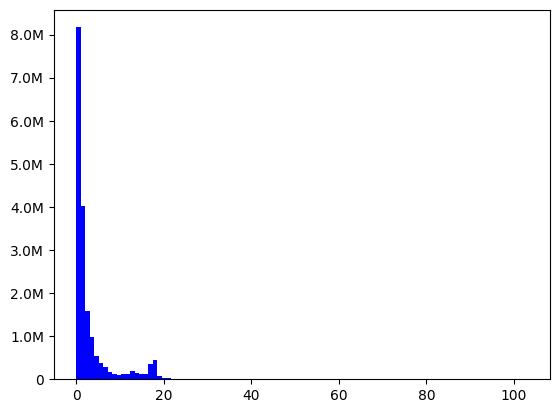

In [ ]:
fig, ax = plt.subplots()
hist(ax, final_df.select('trip_miles'), bins = 100, color=['blue'])

(array([1.493100e+04, 4.737137e+06, 5.820899e+06, 2.509766e+06,
        1.246068e+06, 7.066410e+05, 4.275110e+05, 2.636330e+05,
        1.928060e+05, 2.027260e+05, 2.990500e+05, 2.602910e+05,
        2.702080e+05, 6.932850e+05, 3.405420e+05, 9.744900e+04,
        4.341000e+04, 2.196200e+04, 2.264200e+04, 1.688600e+04,
        1.281700e+04, 1.086000e+04, 1.048700e+04, 8.742000e+03,
        5.325000e+03, 4.284000e+03, 3.446000e+03, 2.759000e+03,
        2.111000e+03, 1.809000e+03, 1.639000e+03, 1.239000e+03,
        1.031000e+03, 9.230000e+02, 6.090000e+02, 6.030000e+02,
        4.950000e+02, 4.360000e+02, 3.840000e+02, 2.650000e+02,
        2.840000e+02, 2.470000e+02, 2.090000e+02, 2.090000e+02,
        1.640000e+02, 1.780000e+02, 1.720000e+02, 1.110000e+02,
        1.050000e+02, 8.400000e+01, 8.100000e+01, 8.300000e+01,
        7.400000e+01, 5.200000e+01, 5.200000e+01, 6.700000e+01,
        5.400000e+01, 3.800000e+01, 3.600000e+01, 4.800000e+01,
        3.500000e+01, 8.700000e+01, 3.40

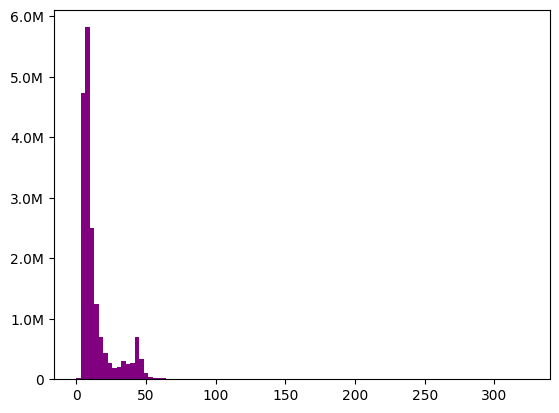

In [ ]:
fig, ax = plt.subplots()
hist(ax, final_df.select('label'), bins = 100, color=['purple'])

The histograms show most of the data falls into the first few bins with a right skew. The right skew would be even greater if I did not filter outliers and would be less if I filtered more outliers using a lower factor in the IQR function.

In [ ]:
# Split the data into training and test sets (30% held out for testing), seed 123 for reproducibility
training, test = final_df.randomSplit([0.7, 0.3], 123)
print(f"Observations in training: {training.count()}")
print(f"Observations in test: {test.count()}")

Observations in training: 12779389
Observations in test: 5481632


## 4. Linear Regression with Elastic Net Regularization

Linear Regression is a machine learning algorithm designed to minimize the squared errors of the residuals in order to fit a linear relationship. The parameters: elasticNetParam and regParam can be set to support Lasso (L1), Ridge (L2), and Elastic Net regularization (L1 + L2).

$$ fare = \beta_0 + \beta_1*tripseconds + \beta_2*tripmiles $$

The default Linear Regression model utilizes no regularization and is an ordinary least squares model. ElasticNetParam is set between 0 (Ridge L2) and 1 (Lasso L1). L1 (Lasso) regularization adds a penalty term to the loss function proportional to the absolute value of the coefficients. L1 effectively drives some coefficients to 0, making it more useful for datasets with irrelevant or redundant features. L2 (Ridge) regularization adds a penalty term to the loss function proportional to the squared values of the coefficients. This forces the coefficients to be more spread out as opposed to L1 which drives them to 0. L2 regularization is useful for reducing the impact of multicollinearity and provides robustness against noise.

RegParam controls the amount of regularization applied to the model. Smaller values mean closer fits (possible overfitting) whereas larger values prevent overfitting by discouraging larger coefficients.

First, let us check the results of a linear regression with no elastic net regularization.

In [ ]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# Initialize LinearRegression object with no elastic net regularization
lr = LinearRegression()
# Fit LR model on training data
lr_model = lr.fit(training)
# Generate predictions on test data
prediction_lr = lr_model.transform(test)

# default regression evaluator is rmse
evaluatorRMSE = RegressionEvaluator()
evaluatorR2 = RegressionEvaluator(metricName="r2")

print(f"RMSE: {evaluatorRMSE.evaluate(prediction_lr)}")
print(f"R2:   {evaluatorR2.evaluate(prediction_lr)}")

RMSE: 5.63991361427755
R2:   0.800085599105497


I obtain a RMSE of 5.64 and a R2 value of 0.80 which is a great score. Next, I will tune the two hyperparameters using a sample of 10% of the final data to save computation time. I also check correlations.

In [ ]:
# Check correlation of features
training.stat.corr('trip_seconds', 'trip_miles')

0.6076890688467939

In [ ]:
# Use 10% of training set to tune the LR model
sample = training.select("*").sample(False, 0.10, seed=123)
print("The sampled dataset contains {} samples.".format(sample.count()))

The sampled dataset contains 1278659 samples.


In [ ]:
# Set up a grid to tune regParam and elasticNetParam
paramGridLR = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.3, 0.5, 0.75, 1]).addGrid(lr.elasticNetParam,[0.0, 0.25, 0.5, 0.75, 1]).build()
# Choose best hyperparameters based on RMSE, using sample set
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGridLR, evaluator=evaluatorRMSE)
cv_lr_model = cv_lr.fit(sample)
best_lr_model = cv_lr_model.bestModel

# Extract and print the best hyperparameters
best_reg_param = best_lr_model._java_obj.getRegParam()
best_elasticnet_param = best_lr_model._java_obj.getElasticNetParam()

print(f"Best regParam: {best_reg_param}")
print(f"Best elasticNetParam: {best_elasticnet_param}")

Best regParam: 0.1
Best elasticNetParam: 0.0


In [ ]:
# Generate a linear regression object - elastic net model
lr_tune = LinearRegression(regParam=best_reg_param, elasticNetParam=best_elasticnet_param)
# Fit model on training data
lr_tune_model = lr_tune.fit(training)
# Forecast fare using test data
prediction_lr_tune = lr_tune_model.transform(test)

rmse_lr = evaluatorRMSE.evaluate(prediction_lr_tune)
r2_lr = evaluatorR2.evaluate(prediction_lr_tune)

print(f"RMSE: {rmse_lr}")
print(f"R2:   {r2_lr}")

RMSE: 5.639573726865513
R2:   0.8001096939216779


I obtained very slightly better RMSE and R2 after tuning. Best elasticNetParam of 0.0 suggests multicollinearity, which the correlation also suggests.

In [ ]:
# Check correlation of features with label
training.stat.corr('trip_seconds', 'label')

0.829519583454541

In [ ]:
training.stat.corr('label', 'trip_miles')

0.7722503599077761

## 5. Decision Tree Model

Decision trees consist of three nodes: root, interior, and leaf. The root node is the initial node representing the entire sample, which will get split into further nodes. Interior nodes represent the features and rules are established to decide how the nodes branch. Finally, the leaf nodes represent the outcome based on established rules from the interior nodes.

Decision trees are useful because they are easy to understand, can be used for regression or classification, do not require a linear relationship, and have almost no hyperparameters to tune.

In [ ]:
# Initialize DecisionTreeRegressor object, seed set for reproducibility
dt = DecisionTreeRegressor(seed=123)
# Fit LR model on training data
dt_model = dt.fit(training)
# Generate predictions on test data
prediction_dt = dt_model.transform(test)

rmse_dt = evaluatorRMSE.evaluate(prediction_dt)
r2_dt = evaluatorR2.evaluate(prediction_dt)

print(f"RMSE: {rmse_dt}")
print(f"R2:   {r2_dt}")

RMSE: 4.248691693634003
R2:   0.886548664897369


In order to view the DT, I followed steps from: https://www.linkedin.com/pulse/visualizing-decisiontree-dtree-model-pyspark-ankit-tanmay/ in order to turn output of toDebugString into a visual.

In [ ]:
# User defined functions taken directly from link above
def parse_debug_string_lines(lines):
    block = []
    while lines:
        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break

    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    return json

In [ ]:
# Taken from link above, copy and paste output into site below
import json
dict_tree_json = debug_str_to_json(dt_model.toDebugString)

print(json.dumps(dict_tree_json,indent = 1 ))

{
 "name": "Root",
 "children": [
  {
   "name": "feature 0 <= 1319.5",
   "children": [
    {
     "name": "feature 1 <= 4.58",
     "children": [
      {
       "name": "feature 0 <= 646.5",
       "children": [
        {
         "name": "feature 0 <= 418.5",
         "children": [
          {
           "name": "feature 0 <= 297.0",
           "children": [
            {
             "name": "Predict: 4.981792653273004"
            }
           ]
          },
          {
           "name": "feature 0 > 297.0",
           "children": [
            {
             "name": "Predict: 6.1650151190180305"
            }
           ]
          }
         ]
        },
        {
         "name": "feature 0 > 418.5",
         "children": [
          {
           "name": "feature 1 <= 2.3049999999999997",
           "children": [
            {
             "name": "Predict: 7.564816653725809"
            }
           ]
          },
          {
           "name": "feature 1 > 2.3049999999999997"

Copy and paste output above into https://vanya.jp.net/vtree/ to generate the tree diagram. Was not able to convert to .svg on my computer, so I took screenshots of the tree.

## 6. Random Forest Model

Random forest algorithms combine ensemble learning methods with bootstrapping using decision trees in order to create multiple randomly drawn trees, averaging the results together in order to produce a model that is less prone to overfitting like a simple decision tree model.

Ensemble learning is merely the process of averaging the results from multiple models trained on the same data. Ensemble learning works best when the errors from each tree are independent and different. By combining decision trees, random forest models tend to have less bias and less variance.

Bootstrapping is the process of randomly sampling subsets of a dataset over a number of iterations with replacement. By default, RandomForestRegressor uses bootstrapping.

In [ ]:
# Initialize RandomForestRegressor object
rf = RandomForestRegressor(seed=123)
# Fit RF model on training data
rf_model = rf.fit(training)
# Generate predictions on test data
prediction_rf = rf_model.transform(test)

print(f"RMSE: {evaluatorRMSE.evaluate(prediction_rf)}")
print(f"R2:   {evaluatorR2.evaluate(prediction_rf)}")

RMSE: 4.390782013296298
R2:   0.8788333980013383


maxBins = Max number of bins for discretizing continuous features.

maxDepth = depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes

numTrees = Number of trees to train.

In [ ]:
# Set up a grid to tune maxDepth (5), maxBins(32), numTrees(20).
paramGridRF = ParamGridBuilder().addGrid(rf.maxDepth, [5, 7, 9]).addGrid(rf.maxBins, [32, 48]).addGrid(rf.numTrees, [10,20,30]).build()
# Choose best hyperparameters based on RMSE
# Default folds for CrossValidator is 3 - generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGridRF, evaluator=evaluatorRMSE)
cv_rf_model = cv_rf.fit(sample)
best_rf_model = cv_rf_model.bestModel

# Extract and print the best hyperparameters
best_maxdepth = best_rf_model._java_obj.getMaxDepth()
best_maxbins = best_rf_model._java_obj.getMaxBins()
best_numtrees = best_rf_model._java_obj.getNumTrees()

print(f"Best maxDepth: {best_maxdepth}")
print(f"Best maxBins: {best_maxbins}")
print(f"Best numTrees: {best_numtrees}")

Best maxDepth: 9
Best maxBins: 48
Best numTrees: 30


In [ ]:
# Generate a RF Regressor object with tuned hyperparameters
rf_tune = RandomForestRegressor(maxDepth=best_maxdepth, maxBins=best_maxbins, numTrees=best_numtrees, seed=123)
# Fit model on training data
rf_tune_model = rf_tune.fit(training)
# Forecast fare using test data
prediction_rf_tune = rf_tune_model.transform(test)

rmse_rf = evaluatorRMSE.evaluate(prediction_rf_tune)
r2_rf = evaluatorR2.evaluate(prediction_rf_tune)

print(f"RMSE: {rmse_rf}")
print(f"R2:   {r2_rf}")

RMSE: 3.7672511751760913
R2:   0.9108033939248941


## 7. Gradient-Boosted Tree

Boosting works by improving on the mistakes of the previous learner via the next learner. In this case, the learners are the decision trees and are considered weak learners. All the trees are connected in series and each tree tries to minimize the error (residuals) of the previous tree. The final model aggregates the results of all the weak learners in order to create a strong learning model.

GBT models have an additional hyperparameter (stepSize) to control the learning rate of the algorithm. Hypertuning the learning rate is key to building a strong GBT model.

In [ ]:
# Initialize GBTRegressor object
gbt = GBTRegressor(seed=123)
# Fit GBT model on training data
gbt_model = gbt.fit(training)
# Generate predictions on test data
prediction_gbt = gbt_model.transform(test)

In [ ]:
print(f"RMSE: {evaluatorRMSE.evaluate(prediction_gbt)}")
print(f"R2:   {evaluatorR2.evaluate(prediction_gbt)}")

RMSE: 3.876919676242267
R2:   0.9055345968943174


In [ ]:
# Set up a grid to tune maxDepth (5), stepSize (0.1).
paramGridGBT = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 7, 9]).addGrid(gbt.stepSize, [0.01, 0.1, 0.25, 0.5]).build()
# Choose best hyperparameters based on RMSE
# Default folds for CrossValidator is 3 - generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing
cv_gbt= CrossValidator(estimator=gbt, estimatorParamMaps=paramGridGBT, evaluator=evaluatorRMSE)
cv_gbt_model = cv_gbt.fit(sample)
best_gbt_model = cv_gbt_model.bestModel

# Extract and print the best hyperparameters
best_gbtdepth = best_gbt_model._java_obj.getMaxDepth()
best_stepsize = best_gbt_model._java_obj.getStepSize()

print(f"Best maxDepth: {best_gbtdepth}")
print(f"Best stepSize: {best_stepsize}")

Best maxDepth: 9
Best stepSize: 0.25


In [ ]:
# Generate a GBT Regressor object with tuned hyperparameters, used values because I had to rerun code
gbt_tune = GBTRegressor(maxDepth=9, stepSize=0.25, seed=123)
# Fit model on training data
gbt_tune_model = gbt_tune.fit(training)
# Forecast fare using test data
prediction_gbt_tune = gbt_tune_model.transform(test)

rmse_gbt = evaluatorRMSE.evaluate(prediction_gbt_tune)
r2_gbt = evaluatorR2.evaluate(prediction_gbt_tune)

print(f"RMSE: {rmse_gbt}")
print(f"R2:   {r2_gbt}")

RMSE: 3.7685921603765573
R2:   0.9107398820370733


## 8. Best model?

In [ ]:
# Output pandas df of all model RMSE and R2
metric = spark.createDataFrame([("LR", rmse_lr, r2_lr), ("DT", rmse_dt, r2_dt),
 ("RF", rmse_rf, r2_rf), ("GBT", rmse_gbt, r2_gbt)], ["Model", "RMSE", "R2"])
metric.toPandas().set_index("Model")

,RMSE,R2
Model,,
LR,5.639574,0.800110
DT,4.248692,0.886549
RF,3.767251,0.910803
GBT,3.768592,0.910740


From the results, the tuned RF model has the lowest RMSE and highest R2 (closest to 1). The difference between GBT and RF performance is minimal, and the DT model is not too far behind either.

## 9. K-Means Clustering

K-means clustering differs from the previous 4 models because it is an unsupervised machine learning algorithm. While we do have target data (fare), clustering divides our data into groups/clusters based on their features without regard for the target label. Note that we must specify K number of clusters. The algorithm works by:

1. Randomly initialize K centroids (mean clusters)
2. Categorize each data point to its closest centroid, updating the centroid's location as the average of all points in the cluster.
3. Iterate until all data points have been assigned and all centroid locations have been updated.

Specifying the number of clusters is crucial and can be done by evaluating Silhouette coefficient. This coefficient contrasts the average distance to points in the same cluster with points in other clusters. A high silhouette coefficient equates to a better clustering.

In [ ]:
from pyspark.ml.feature import StandardScaler

assembler2 = VectorAssembler(inputCols=["trip_seconds", "trip_miles", "label"], outputCol="features")

# Drop features vector column
training2 = training.drop('features')
test2 = training.drop('features')
# Create new features column with label
temp1 = assembler2.transform(training2)
temp2 = assembler2.transform(test2)

# Scale data for Kmeans which has no standarization hyperparameter (withMean = False)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(temp1)

scaled_training = scaler_model.transform(temp1)
scaled_test = scaler_model.transform(temp2)

# Use only sample of 10% of obs to save runtime
ss_training = scaled_training.select("*").sample(False, 0.10, seed=123)
ss_test = scaled_test.select("*").sample(False, 0.10, seed=123)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Silhvalues = []
# Evaluate clustering by computing Silhouette score
cluster = ClusteringEvaluator()

# Obtain best K
for k in range(2, 6):
  kmeans = KMeans(featuresCol="scaled_features").setK(k).setSeed(123)
  model = kmeans.fit(ss_training)

  # Make predictions
  predictions = model.transform(ss_test)
  silhouette = cluster.evaluate(predictions)
  Silhvalues.append(silhouette)
Silhvalues

[0.8118268076168498, 0.7737291182630434, 0.530518096572339, 0.5175645223946633]

In [ ]:
# Find best K
bestk = 2 + np.argmax(Silhvalues)
print(f"Best K: {bestk}")

Best K: 2


While the best K is 2, I choose to use 3 instead as the silhouette score is very close and having only 2 clusters may not tell us much.

In [ ]:
# Fit K-means using bestk
kmeans = KMeans(featuresCol="scaled_features").setK(3).setSeed(123)
model = kmeans.fit(ss_training)
predictions = model.transform(ss_test)

# 3 columns representing the average of the 3 features for each cluster
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.50709173 2.21765365 3.02207069]
[0.74704776 0.28053634 0.71900042]
[5.04256556 3.78621174 4.33135555]


In [ ]:
# Plot the Clusters using pd df
from matplotlib.pyplot import figure
pandas_df = predictions.toPandas()

<Figure size 640x480 with 0 Axes>

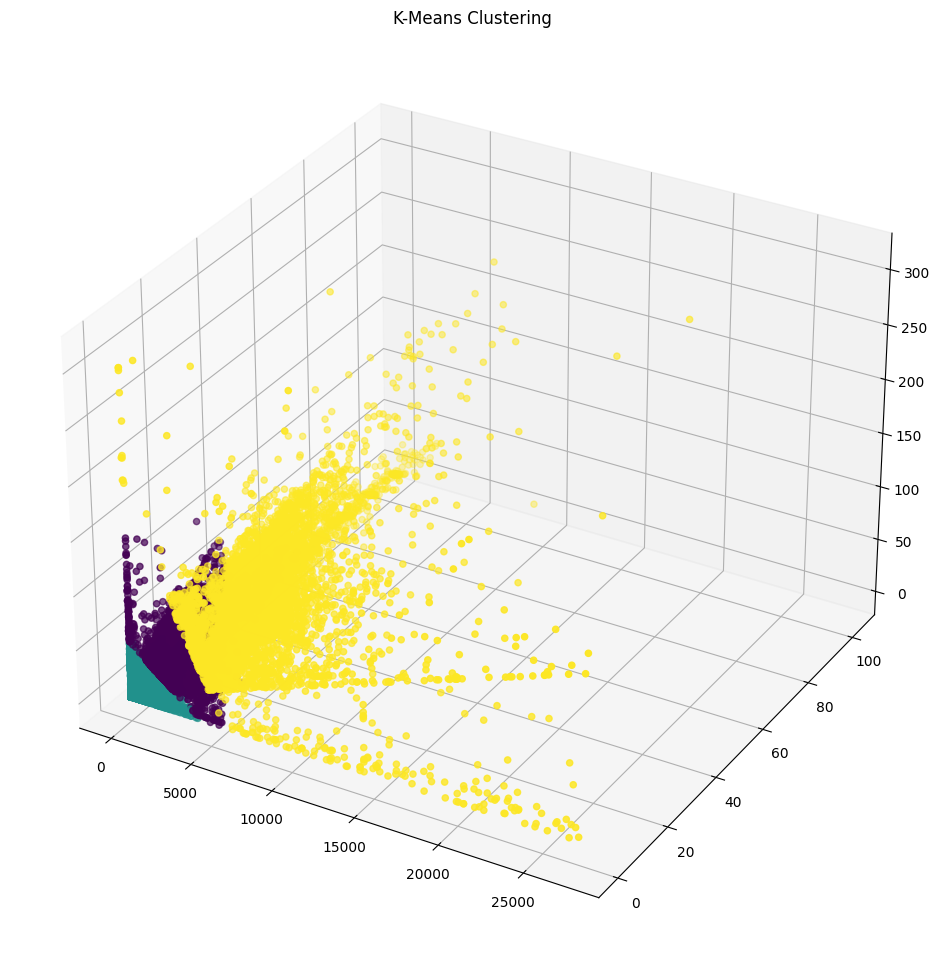

In [ ]:
fig = plt.figure()
figure(figsize=(12,12))

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining axes
z = pandas_df['label']
x = pandas_df['trip_seconds']
y = pandas_df['trip_miles']
c = pandas_df['prediction']
ax.scatter(x, y, z, c = c)

# plot
ax.set_title('K-Means Clustering')
plt.show()

In [ ]:
# View every parameter of the best model, had to rerun code so using set values for rf regressor object
rf_tune = RandomForestRegressor(maxDepth=9, maxBins=48, numTrees=30, seed=123)
{param[0].name: param[1] for param in rf_tune.extractParamMap().items()}

{'seed': 123,
 'maxDepth': 9,
 'maxBins': 48,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'variance',
 'subsamplingRate': 1.0,
 'numTrees': 30,
 'featureSubsetStrategy': 'auto',
 'leafCol': '',
 'minWeightFractionPerNode': 0.0,
 'bootstrap': True,
 'predictionCol': 'prediction',
 'featuresCol': 'features',
 'labelCol': 'label'}